# **Homework 4: Pedestrian Trajectory Prediction**



Objectives:
* Get familiar with pedestrian trajectory prediction.
* Understand the basic pipeline of YNet.
* Solve a trajectory problem with YNet.

If any questions, please contact the TAs via TA hours, or email.


In [ ]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


# **Download and unzip files**

In [1]:
try:
  !rm -rf HW4_trajectory
except:
  pass

# Get some essential codes
!git clone https://github.com/JamesLiang819/HW4_trajectory.git

# Download pre-trained weights, data and masks for YNet
!gdown 1FgOtWWwDkvRMCpe7SjZbdz4nn-KwN2en

# Install pickle5
!pip3 install pickle5
!pip install segmentation-models-pytorch==0.1.0

# Unzip
! unzip ynet_additional_files.zip

from IPython.display import clear_output
clear_output()

In [2]:
from __future__ import print_function

# Basic models and utils
from HW4_trajectory.utils.kmeans import kmeans
from HW4_trajectory.utils.softargmax import SoftArgmax2D, create_meshgrid
from HW4_trajectory.utils.preprocessing import augment_data, create_images_dict
from HW4_trajectory.utils.image_utils import create_gaussian_heatmap_template, create_dist_mat, preprocess_image_for_segmentation, pad, resize, get_patch, image2world, sampling
from HW4_trajectory.utils.dataloader import SceneDataset, scene_collate
import segmentation_models_pytorch

# System
import os, sys, time, datetime, random
import argparse
from tqdm import tqdm

# Data processing
import numpy as np
import pandas as pd
import yaml
import pickle5 as pickle

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

# Image processing
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from skimage import io

# **Pedestrian trajectory prediction with pre-trained YNet**

## **About the YNet**

Y-Net is a scene-compliant trajectory forecasting network with factorized goal and path multimodalities.

It uses the U-net structure for explicitly modeling probability heatmaps for epistemic and aleatoric uncertainties.

For more details, please refer to [From Goals, Waypoints & Paths To Long Term Human Trajectory Forecasting](https://arxiv.org/abs/2012.01526).

# Basic function

## Train

In [3]:
def train(model, train_loader, train_images, e, obs_len, pred_len, batch_size, params, gt_template, device, input_template, optimizer, criterion, dataset_name, homo_mat):
	"""
	Run training for one epoch
	:param model: torch model
	:param train_loader: torch dataloader
	:param train_images: dict with keys: scene_name value: preprocessed image as torch.Tensor
	:param e: epoch number
	:param params: dict of hyperparameters
	:param gt_template:  precalculated Gaussian heatmap template as torch.Tensor
	:return: train_ADE, train_FDE, train_loss for one epoch
	"""
	train_loss = 0
	train_ADE = []
	train_FDE = []
	model.train()
	counter = 0
	# outer loop, for loop over each scene as scenes have different image size and to calculate segmentation only once
	for batch, (trajectory, meta, scene) in enumerate(train_loader):
		# Stop training after 25 batches to increase evaluation frequency
		if dataset_name == 'sdd' and obs_len == 8 and batch > 25:
			break

		# Get scene image and apply semantic segmentation
		if e < params['unfreeze']:  # before unfreeze only need to do semantic segmentation once
			model.eval()
			scene_image = train_images[scene].to(device).unsqueeze(0)
			scene_image = model.segmentation(scene_image)
			model.train()

		# inner loop, for each trajectory in the scene
		for i in range(0, len(trajectory), batch_size):
			if e >= params['unfreeze']:
				scene_image = train_images[scene].to(device).unsqueeze(0)
				scene_image = model.segmentation(scene_image)

			# Create Heatmaps for past and ground-truth future trajectories
			_, _, H, W = scene_image.shape  # image shape

			observed = trajectory[i:i+batch_size, :obs_len, :].reshape(-1, 2).cpu().numpy()
			observed_map = get_patch(input_template, observed, H, W)
			observed_map = torch.stack(observed_map).reshape([-1, obs_len, H, W])

			gt_future = trajectory[i:i + batch_size, obs_len:].to(device)
			gt_future_map = get_patch(gt_template, gt_future.reshape(-1, 2).cpu().numpy(), H, W)
			gt_future_map = torch.stack(gt_future_map).reshape([-1, pred_len, H, W])

			gt_waypoints = gt_future[:, params['waypoints']]
			gt_waypoint_map = get_patch(input_template, gt_waypoints.reshape(-1, 2).cpu().numpy(), H, W)
			gt_waypoint_map = torch.stack(gt_waypoint_map).reshape([-1, gt_waypoints.shape[1], H, W])

			# Concatenate heatmap and semantic map
			semantic_map = scene_image.expand(observed_map.shape[0], -1, -1, -1)  # expand to match heatmap size
			feature_input = torch.cat([semantic_map, observed_map], dim=1)

			# Forward pass
			# Calculate features
			features = model.pred_features(feature_input)

			# Predict goal and waypoint probability distribution
			pred_goal_map = model.pred_goal(features)
			goal_loss = criterion(pred_goal_map, gt_future_map) * params['loss_scale']  # BCEWithLogitsLoss

			# Prepare (downsample) ground-truth goal and trajectory heatmap representation for conditioning trajectory decoder
			gt_waypoints_maps_downsampled = [nn.AvgPool2d(kernel_size=2**i, stride=2**i)(gt_waypoint_map) for i in range(1, len(features))]
			gt_waypoints_maps_downsampled = [gt_waypoint_map] + gt_waypoints_maps_downsampled

			# Predict trajectory distribution conditioned on goal and waypoints
			traj_input = [torch.cat([feature, goal], dim=1) for feature, goal in zip(features, gt_waypoints_maps_downsampled)]
			pred_traj_map = model.pred_traj(traj_input)
			traj_loss = criterion(pred_traj_map, gt_future_map) * params['loss_scale']

			# Backprop
			loss = goal_loss + traj_loss
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			with torch.no_grad():
				train_loss += loss
				# Evaluate using Softargmax, not a very exact evaluation but a lot faster than full prediction
				pred_traj = model.softargmax(pred_traj_map)
				pred_goal = model.softargmax(pred_goal_map[:, -1:])

				train_ADE.append(((((gt_future - pred_traj) / params['resize']) ** 2).sum(dim=2) ** 0.5).mean(dim=1))
				train_FDE.append(((((gt_future[:, -1:] - pred_goal[:, -1:]) / params['resize']) ** 2).sum(dim=2) ** 0.5).mean(dim=1))

	train_ADE = torch.cat(train_ADE).mean()
	train_FDE = torch.cat(train_FDE).mean()

	return train_ADE.item(), train_FDE.item(), train_loss.item()

## Heatmap

In [4]:
def torch_multivariate_gaussian_heatmap(coordinates, H, W, dist, sigma_factor, ratio, device, rot=False):
	"""
	Create Gaussian Kernel for CWS
	"""
	ax = torch.linspace(0, H, H, device=device) - coordinates[1]
	ay = torch.linspace(0, W, W, device=device) - coordinates[0]
	xx, yy = torch.meshgrid([ax, ay])
	meshgrid = torch.stack([yy, xx], dim=-1)
	radians = torch.atan2(dist[0], dist[1])

	c, s = torch.cos(radians), torch.sin(radians)
	R = torch.Tensor([[c, s], [-s, c]]).to(device)
	if rot:
		R = torch.matmul(torch.Tensor([[0, -1], [1, 0]]).to(device), R)
	dist_norm = dist.square().sum(-1).sqrt() + 5  # some small padding to avoid division by zero

	conv = torch.Tensor([[dist_norm / sigma_factor / ratio, 0], [0, dist_norm / sigma_factor]]).to(device)
	conv = torch.square(conv)
	T = torch.matmul(R, conv)
	T = torch.matmul(T, R.T)

	kernel = (torch.matmul(meshgrid, torch.inverse(T)) * meshgrid).sum(-1)
	kernel = torch.exp(-0.5 * kernel)
	return kernel / kernel.sum()

## Evaluate

In [5]:
def evaluate(model, val_loader, val_images, num_goals, num_traj, obs_len, batch_size, device, input_template, waypoints, resize, temperature, use_TTST=False, use_CWS=False, rel_thresh=0.002, CWS_params=None, dataset_name=None, homo_mat=None, mode='val', vis = False):
	"""
	:param model: torch model
	:param val_loader: torch dataloader
	:param val_images: dict with keys: scene_name value: preprocessed image as torch.Tensor
	:param num_goals: int, number of goals
	:param num_traj: int, number of trajectories per goal
	:param obs_len: int, observed timesteps
	:param batch_size: int, batch_size
	:param device: torch device
	:param input_template: torch.Tensor, heatmap template
	:param waypoints: number of waypoints
	:param resize: resize factor
	:param temperature: float, temperature to control peakiness of heatmap
	:param use_TTST: bool
	:param use_CWS: bool
	:param rel_thresh: float
	:param CWS_params: dict
	:param dataset_name: ['sdd']
	:param params: dict with hyperparameters
	:param homo_mat: dict with homography matrix
	:param mode: ['val', 'test']
	:return: val_ADE, val_FDE for one epoch
	"""
	model.eval()
	val_ADE = []
	val_FDE = []
	counter = 0
	all_future_samples = []
	with torch.no_grad():
		# outer loop, for loop over each scene as scenes have different image size and to calculate segmentation only once
		for trajectory, meta, scene in val_loader:
			# Get scene image and apply semantic segmentation
			scene_image = val_images[scene].to(device).unsqueeze(0)
			scene_image = model.segmentation(scene_image)

			for i in range(0, len(trajectory), batch_size):
				# Create Heatmaps for past and ground-truth future trajectories
				_, _, H, W = scene_image.shape
				observed = trajectory[i:i+batch_size, :obs_len, :].reshape(-1, 2).cpu().numpy()
				observed_map = get_patch(input_template, observed, H, W)
				observed_map = torch.stack(observed_map).reshape([-1, obs_len, H, W])

				gt_future = trajectory[i:i+batch_size, obs_len:].to(device)
				semantic_image = scene_image.expand(observed_map.shape[0], -1, -1, -1)

				# Forward pass
				# Calculate features
				feature_input = torch.cat([semantic_image, observed_map], dim=1)
				features = model.pred_features(feature_input)

				# Predict goal and waypoint probability distributions
				pred_waypoint_map = model.pred_goal(features)
				pred_waypoint_map = pred_waypoint_map[:, waypoints]

				pred_waypoint_map_sigmoid = pred_waypoint_map / temperature
				pred_waypoint_map_sigmoid = model.sigmoid(pred_waypoint_map_sigmoid)

				################################################ TTST ##################################################
				if use_TTST:
					# TTST Begin
					# sample a large amount of goals to be clustered
					goal_samples = sampling(pred_waypoint_map_sigmoid[:, -1:], num_samples=10000, replacement=True, rel_threshold=rel_thresh)
					goal_samples = goal_samples.permute(2, 0, 1, 3)

					num_clusters = num_goals - 1
					goal_samples_softargmax = model.softargmax(pred_waypoint_map[:, -1:])  # first sample is softargmax sample

					# Iterate through all person/batch_num, as this k-Means implementation doesn't support batched clustering
					goal_samples_list = []
					for person in range(goal_samples.shape[1]):
						goal_sample = goal_samples[:, person, 0]

						# Actual k-means clustering, Outputs:
						# cluster_ids_x -  Information to which cluster_idx each point belongs to
						# cluster_centers - list of centroids, which are our new goal samples
						cluster_ids_x, cluster_centers = kmeans(X=goal_sample, num_clusters=num_clusters, distance='euclidean', device=device, tqdm_flag=False, tol=0.001, iter_limit=1000)
						goal_samples_list.append(cluster_centers)

					goal_samples = torch.stack(goal_samples_list).permute(1, 0, 2).unsqueeze(2)
					goal_samples = torch.cat([goal_samples_softargmax.unsqueeze(0), goal_samples], dim=0)
					# TTST End

				# Not using TTST
				else:
					goal_samples = sampling(pred_waypoint_map_sigmoid[:, -1:], num_samples=num_goals)
					goal_samples = goal_samples.permute(2, 0, 1, 3)

				# Predict waypoints:
				# in case len(waypoints) == 1, so only goal is needed (goal counts as one waypoint in this implementation)
				if len(waypoints) == 1:
					waypoint_samples = goal_samples

				################################################ CWS ###################################################
				# CWS Begin
				if use_CWS and len(waypoints) > 1:
					sigma_factor = CWS_params['sigma_factor']
					ratio = CWS_params['ratio']
					rot = CWS_params['rot']

					goal_samples = goal_samples.repeat(num_traj, 1, 1, 1)  # repeat K_a times
					last_observed = trajectory[i:i+batch_size, obs_len-1].to(device)  # [N, 2]
					waypoint_samples_list = []  # in the end this should be a list of [K, N, # waypoints, 2] waypoint coordinates
					for g_num, waypoint_samples in enumerate(goal_samples.squeeze(2)):
						waypoint_list = []  # for each K sample have a separate list
						waypoint_list.append(waypoint_samples)

						for waypoint_num in reversed(range(len(waypoints)-1)):
							distance = last_observed - waypoint_samples
							gaussian_heatmaps = []
							traj_idx = g_num // num_goals  # idx of trajectory for the same goal
							for dist, coordinate in zip(distance, waypoint_samples):  # for each person
								length_ratio = 1 / (waypoint_num + 2)
								gauss_mean = coordinate + (dist * length_ratio)  # Get the intermediate point's location using CV model
								sigma_factor_ = sigma_factor - traj_idx
								gaussian_heatmaps.append(torch_multivariate_gaussian_heatmap(gauss_mean, H, W, dist, sigma_factor_, ratio, device, rot))
							gaussian_heatmaps = torch.stack(gaussian_heatmaps)  # [N, H, W]

							waypoint_map_before = pred_waypoint_map_sigmoid[:, waypoint_num]
							waypoint_map = waypoint_map_before * gaussian_heatmaps
							# normalize waypoint map
							waypoint_map = (waypoint_map.flatten(1) / waypoint_map.flatten(1).sum(-1, keepdim=True)).view_as(waypoint_map)

							# For first traj samples use softargmax
							if g_num // num_goals == 0:
								# Softargmax
								waypoint_samples = model.softargmax_on_softmax_map(waypoint_map.unsqueeze(0))
								waypoint_samples = waypoint_samples.squeeze(0)
							else:
								waypoint_samples = sampling(waypoint_map.unsqueeze(1), num_samples=1, rel_threshold=0.05)
								waypoint_samples = waypoint_samples.permute(2, 0, 1, 3)
								waypoint_samples = waypoint_samples.squeeze(2).squeeze(0)
							waypoint_list.append(waypoint_samples)

						waypoint_list = waypoint_list[::-1]
						waypoint_list = torch.stack(waypoint_list).permute(1, 0, 2)  # permute back to [N, # waypoints, 2]
						waypoint_samples_list.append(waypoint_list)
					waypoint_samples = torch.stack(waypoint_samples_list)

					# CWS End

				# If not using CWS, and we still need to sample waypoints (i.e., not only goal is needed)
				elif not use_CWS and len(waypoints) > 1:
					waypoint_samples = sampling(pred_waypoint_map_sigmoid[:, :-1], num_samples=num_goals * num_traj)
					waypoint_samples = waypoint_samples.permute(2, 0, 1, 3)
					goal_samples = goal_samples.repeat(num_traj, 1, 1, 1)  # repeat K_a times
					waypoint_samples = torch.cat([waypoint_samples, goal_samples], dim=2)

				# Interpolate trajectories given goal and waypoints
				future_samples = []
				for waypoint in waypoint_samples:
					waypoint_map = get_patch(input_template, waypoint.reshape(-1, 2).cpu().numpy(), H, W)
					waypoint_map = torch.stack(waypoint_map).reshape([-1, len(waypoints), H, W])

					waypoint_maps_downsampled = [nn.AvgPool2d(kernel_size=2 ** i, stride=2 ** i)(waypoint_map) for i in range(1, len(features))]
					waypoint_maps_downsampled = [waypoint_map] + waypoint_maps_downsampled

					traj_input = [torch.cat([feature, goal], dim=1) for feature, goal in zip(features, waypoint_maps_downsampled)]

					pred_traj_map = model.pred_traj(traj_input)
					pred_traj = model.softargmax(pred_traj_map)
					future_samples.append(pred_traj)
					all_future_samples.append(future_samples)
				future_samples = torch.stack(future_samples)


				gt_goal = gt_future[:, -1:]

				val_FDE.append(((((gt_goal - waypoint_samples[:, :, -1:]) / resize) ** 2).sum(dim=3) ** 0.5).min(dim=0)[0])
				val_ADE.append(((((gt_future - future_samples) / resize) ** 2).sum(dim=3) ** 0.5).mean(dim=2).min(dim=0)[0])


		val_ADE = torch.cat(val_ADE).mean()
		val_FDE = torch.cat(val_FDE).mean()
	if vis:
		return future_samples
	else:
		return val_ADE.item(), val_FDE.item()

## YNetEncoder (50pts)

In [6]:
class YNetEncoder(nn.Module):
	def __init__(self, in_channels, channels=(64, 128, 256, 512, 512)):
		"""
		Encoder model
		:param in_channels: int, semantic_classes + obs_len
		:param channels: list, hidden layer channels
		"""
		super(YNetEncoder, self).__init__()
		self.stages = nn.ModuleList()

	  #TODO(50pts): write encoder layers
		#Requirements:
		# 1. One Conv2d layer to start with (10pts)
    # 2. For every channel, use one max pool layer followed by two Conv2d layers (30pts)
		# 3. Finish with 1 last max pool layer (10pts)
		# 3. Determine layer sizes according to the arguments
		# 4. Don't forget the activation function, ReLU is recommanded

		self.stages.append(nn.Sequential(
			nn.Conv2d(in_channels, channels[0], kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
			nn.ReLU(inplace=True),
		))

		for i in range(len(channels)-1):
			self.stages.append(nn.Sequential(
				nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
				nn.Conv2d(channels[i], channels[i+1], kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
				nn.ReLU(inplace=True),
				nn.Conv2d(channels[i+1], channels[i+1], kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
				nn.ReLU(inplace=True)))

		self.stages.append(nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)))

	def forward(self, x):
		# Saves the feature maps Tensor of each layer into a list, as we will later need them again for the decoder
		features = []
		for stage in self.stages:
			x = stage(x)
			features.append(x)
		return features

## YNetDecoder

In [7]:
class YNetDecoder(nn.Module):
	def __init__(self, encoder_channels, decoder_channels, output_len, traj=False):
		"""
		Decoder models
		:param encoder_channels: list, encoder channels, used for skip connections
		:param decoder_channels: list, decoder channels
		:param output_len: int, pred_len
		:param traj: False or int, if False -> Goal and waypoint predictor, if int -> number of waypoints
		"""
		super(YNetDecoder, self).__init__()

		# The trajectory decoder takes in addition the conditioned goal and waypoints as an additional image channel
		if traj:
			encoder_channels = [channel+traj for channel in encoder_channels]
		encoder_channels = encoder_channels[::-1]
		center_channels = encoder_channels[0]

		decoder_channels = decoder_channels

		# The center layer (the layer with the smallest feature map size)
		self.center = nn.Sequential(
			nn.Conv2d(center_channels, center_channels*2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
			nn.ReLU(inplace=True),
			nn.Conv2d(center_channels*2, center_channels*2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
			nn.ReLU(inplace=True)
		)

		# Determine the upsample channel dimensions
		upsample_channels_in = [center_channels*2] + decoder_channels[:-1]
		upsample_channels_out = [num_channel // 2 for num_channel in upsample_channels_in]

		# Upsampling consists of bilinear upsampling + 3x3 Conv, here the 3x3 Conv is defined
		self.upsample_conv = [
			nn.Conv2d(in_channels_, out_channels_, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
			for in_channels_, out_channels_ in zip(upsample_channels_in, upsample_channels_out)]
		self.upsample_conv = nn.ModuleList(self.upsample_conv)

		# Determine the input and output channel dimensions of each layer in the decoder
		# As we concat the encoded feature and decoded features we have to sum both dims
		in_channels = [enc + dec for enc, dec in zip(encoder_channels, upsample_channels_out)]
		out_channels = decoder_channels

		self.decoder = [nn.Sequential(
			nn.Conv2d(in_channels_, out_channels_, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
			nn.ReLU(inplace=True),
			nn.Conv2d(out_channels_, out_channels_, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
			nn.ReLU(inplace=True))
			for in_channels_, out_channels_ in zip(in_channels, out_channels)]
		self.decoder = nn.ModuleList(self.decoder)


		# Final 1x1 Conv prediction to get our heatmap logits (before softmax)
		self.predictor = nn.Conv2d(in_channels=decoder_channels[-1], out_channels=output_len, kernel_size=1, stride=1, padding=0)

	def forward(self, features):
		# Takes in the list of feature maps from the encoder. Trajectory predictor in addition the goal and waypoint heatmaps
		features = features[::-1]  # reverse the order of encoded features, as the decoder starts from the smallest image
		center_feature = features[0]
		x = self.center(center_feature)
		for i, (feature, module, upsample_conv) in enumerate(zip(features[1:], self.decoder, self.upsample_conv)):
			x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
			x = upsample_conv(x)  # 3x3 conv for upsampling
			x = torch.cat([x, feature], dim=1)  # concat encoder and decoder features
			x = module(x)  # Conv
		x = self.predictor(x)  # last predictor layer
		return x

## YNetTorch (40pts)

In [8]:
class YNetTorch(nn.Module):
	def __init__(self, obs_len, pred_len, segmentation_model_fp, use_features_only=False, semantic_classes=6,
				 encoder_channels=[], decoder_channels=[], waypoints=1):
		"""
		Complete Y-net Architecture including semantic segmentation backbone, heatmap embedding and ConvPredictor
		:param obs_len: int, observed timesteps
		:param pred_len: int, predicted timesteps
		:param segmentation_model_fp: str, filepath to pretrained segmentation model
		:param use_features_only: bool, if True -> use segmentation features from penultimate layer, if False -> use softmax class predictions
		:param semantic_classes: int, number of semantic classes
		:param encoder_channels: list, encoder channel structure
		:param decoder_channels: list, decoder channel structure
		:param waypoints: int, number of waypoints
		"""
		super(YNetTorch, self).__init__()

		if segmentation_model_fp is not None:
			self.semantic_segmentation = torch.load(segmentation_model_fp)
			if use_features_only:
				self.semantic_segmentation.segmentation_head = nn.Identity()
				semantic_classes = 16  # instead of classes use number of feature_dim
		else:
			self.semantic_segmentation = nn.Identity()


    #TODO: fill encoder and decoders
		#Hint: Please refer to the class definitions, parameters especially
		self.encoder = YNetEncoder(in_channels=semantic_classes + obs_len, channels=encoder_channels) #TODO (5pts)

		self.goal_decoder = YNetDecoder(encoder_channels, decoder_channels, output_len=pred_len) #TODO (5pts)
		self.traj_decoder = YNetDecoder(encoder_channels, decoder_channels, output_len=pred_len, traj=waypoints) #TODO (5pts) # with waypoints

		self.softargmax_ = SoftArgmax2D(normalized_coordinates=False)

	def segmentation(self, image):
		return self.semantic_segmentation(image)

	# Forward pass for goal decoder
	def pred_goal(self, features):
		return self.goal_decoder(features) #TODO (5pts)

	# Forward pass for trajectory decoder
	def pred_traj(self, features):
		return self.traj_decoder(features) #TODO (5pts)

	# Forward pass for feature encoder, returns list of feature maps
	def pred_features(self, x):
		return self.encoder(x) #TODO (5pts)

	# Softargmax for Image data as in dim=NxCxHxW, returns 2D coordinates=Nx2
	def softargmax(self, output):
		return self.softargmax_(output) #TODO (5pts)

	def sigmoid(self, output):
		return torch.sigmoid(output) #TODO (5pts)

	# Softmax for Image data as in dim=NxCxHxW, returns softmax image shape=NxCxHxW
	def softmax(self, x):
		return nn.Softmax(2)(x.view(*x.size()[:2], -1)).view_as(x)

	def softargmax_on_softmax_map(self, x):
		""" Softargmax: As input a batched image where softmax is already performed (not logits) """
		pos_y, pos_x = create_meshgrid(x, normalized_coordinates=False)
		pos_x = pos_x.reshape(-1)
		pos_y = pos_y.reshape(-1)
		x = x.flatten(2)

		estimated_x = pos_x * x
		estimated_x = torch.sum(estimated_x, dim=-1, keepdim=True)
		estimated_y = pos_y * x
		estimated_y = torch.sum(estimated_y, dim=-1, keepdim=True)
		softargmax_coords = torch.cat([estimated_x, estimated_y], dim=-1)
		return softargmax_coords

## YNet

In [9]:
class YNet:
	def __init__(self, obs_len, pred_len, params):
		"""
		Ynet class, following a sklearn similar class structure
		:param obs_len: observed timesteps
		:param pred_len: predicted timesteps
		:param params: dictionary with hyperparameters
		"""
		self.obs_len = obs_len
		self.pred_len = pred_len
		self.division_factor = 2 ** len(params['encoder_channels'])

		self.model = YNetTorch(obs_len=obs_len,
							   pred_len=pred_len,
							   segmentation_model_fp=params['segmentation_model_fp'],
							   use_features_only=params['use_features_only'],
							   semantic_classes=params['semantic_classes'],
							   encoder_channels=params['encoder_channels'],
							   decoder_channels=params['decoder_channels'],
							   waypoints=len(params['waypoints']))
	def train(self, train_data, val_data, params, train_image_path, val_image_path, experiment_name, batch_size=8, num_goals=20, num_traj=1, device=None, dataset_name=None):
		"""
		Train function
		:param train_data: pd.df, train data
		:param val_data: pd.df, val data
		:param params: dictionary with training hyperparameters
		:param train_image_path: str, filepath to train images
		:param val_image_path: str, filepath to val images
		:param experiment_name: str, arbitrary name to name weights file
		:param batch_size: int, batch size
		:param num_goals: int, number of goals per trajectory, K_e in paper
		:param num_traj: int, number of trajectory per goal, K_a in paper
		:param device: torch.device, if None -> 'cuda' if torch.cuda.is_available() else 'cpu'
		:return:
		"""
		if device is None:
			device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

		obs_len = self.obs_len
		pred_len = self.pred_len
		total_len = pred_len + obs_len

		print('Preprocess data')
		dataset_name = dataset_name.lower()
		if dataset_name == 'sdd':
			image_file_name = 'reference.jpg'
		else:
			raise ValueError(f'{dataset_name} dataset is not supported')

		self.homo_mat = None
		seg_mask = False

		# Load train images and augment train data and images
		df_train, train_images = augment_data(train_data, image_path=train_image_path, image_file=image_file_name,
											  seg_mask=seg_mask)

		# Load val scene images
		val_images = create_images_dict(val_data, image_path=val_image_path, image_file=image_file_name)

		# Initialize dataloaders
		train_dataset = SceneDataset(df_train, resize=params['resize'], total_len=total_len)
		train_loader = DataLoader(train_dataset, batch_size=1, collate_fn=scene_collate, shuffle=True)

		val_dataset = SceneDataset(val_data, resize=params['resize'], total_len=total_len)
		val_loader = DataLoader(val_dataset, batch_size=1, collate_fn=scene_collate)

		# Preprocess images, in particular resize, pad and normalize as semantic segmentation backbone requires
		resize(train_images, factor=params['resize'], seg_mask=seg_mask)
		pad(train_images, division_factor=self.division_factor)  # make sure that image shape is divisible by 32, for UNet segmentation
		preprocess_image_for_segmentation(train_images, seg_mask=seg_mask)

		resize(val_images, factor=params['resize'], seg_mask=seg_mask)
		pad(val_images, division_factor=self.division_factor)  # make sure that image shape is divisible by 32, for UNet segmentation
		preprocess_image_for_segmentation(val_images, seg_mask=seg_mask)

		model = self.model.to(device)

		# Freeze segmentation model
		for param in model.semantic_segmentation.parameters():
			param.requires_grad = False

		optimizer = torch.optim.Adam(model.parameters(), lr=params["learning_rate"])
		criterion = nn.BCEWithLogitsLoss()

		# Create template
		size = int(4200 * params['resize'])

		input_template = create_dist_mat(size=size)
		input_template = torch.Tensor(input_template).to(device)

		gt_template = create_gaussian_heatmap_template(size=size, kernlen=params['kernlen'], nsig=params['nsig'], normalize=False)
		gt_template = torch.Tensor(gt_template).to(device)

		best_test_ADE = 99999999999999

		self.train_ADE = []
		self.train_FDE = []
		self.val_ADE = []
		self.val_FDE = []

		print('Start training')
		for e in tqdm(range(params['num_epochs']), desc='Epoch'):
			train_ADE, train_FDE, train_loss = train(model, train_loader, train_images, e, obs_len, pred_len,
													 batch_size, params, gt_template, device,
													 input_template, optimizer, criterion, dataset_name, self.homo_mat)
			self.train_ADE.append(train_ADE)
			self.train_FDE.append(train_FDE)

			# For faster inference, we don't use TTST and CWS here, only for the test set evaluation
			val_ADE, val_FDE = evaluate(model, val_loader, val_images, num_goals, num_traj,
										obs_len=obs_len, batch_size=batch_size,
										device=device, input_template=input_template,
										waypoints=params['waypoints'], resize=params['resize'],
										temperature=params['temperature'], use_TTST=False,
										use_CWS=False, dataset_name=dataset_name,
										homo_mat=self.homo_mat, mode='val')
			print(f'Epoch {e}: \nVal ADE: {val_ADE} \nVal FDE: {val_FDE}')
			self.val_ADE.append(val_ADE)
			self.val_FDE.append(val_FDE)

			if val_ADE < best_test_ADE:
				print(f'Best Epoch {e}: \nVal ADE: {val_ADE} \nVal FDE: {val_FDE}')
				torch.save(model.state_dict(), '/content/ynet_additional_files/pretrained_models/' + experiment_name + '_weights.pt')
				best_test_ADE = val_ADE

	def evaluate(self, data, params, image_path, batch_size=8, num_goals=20, num_traj=1, rounds=1, device=None, dataset_name=None, vis = False):
		"""
		Val function
		:param data: pd.df, val data
		:param params: dictionary with training hyperparameters
		:param image_path: str, filepath to val images
		:param batch_size: int, batch size
		:param num_goals: int, number of goals per trajectory, K_e in paper
		:param num_traj: int, number of trajectory per goal, K_a in paper
		:param rounds: int, number of epochs to evaluate
		:param device: torch.device, if None -> 'cuda' if torch.cuda.is_available() else 'cpu'
		:return:
		"""

		if device is None:
			device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

		obs_len = self.obs_len
		pred_len = self.pred_len
		total_len = pred_len + obs_len

		print('Preprocess data')
		dataset_name = dataset_name.lower()
		if dataset_name == 'sdd':
			image_file_name = 'reference.jpg'
		else:
			raise ValueError(f'{dataset_name} dataset is not supported')

		self.homo_mat = None
		seg_mask = False

		test_images = create_images_dict(data, image_path=image_path, image_file=image_file_name)

		test_dataset = SceneDataset(data, resize=params['resize'], total_len=total_len)
		test_loader = DataLoader(test_dataset, batch_size=1, collate_fn=scene_collate)

		# Preprocess images, in particular resize, pad and normalize as semantic segmentation backbone requires
		resize(test_images, factor=params['resize'], seg_mask=seg_mask)
		pad(test_images, division_factor=self.division_factor)  # make sure that image shape is divisible by 32, for UNet architecture
		preprocess_image_for_segmentation(test_images, seg_mask=seg_mask)

		model = self.model.to(device)

		# Create template
		size = int(4200 * params['resize'])

		input_template = torch.Tensor(create_dist_mat(size=size)).to(device)

		self.eval_ADE = []
		self.eval_FDE = []

		if not vis:
			print('Start testing')
			for e in tqdm(range(rounds), desc='Round'):
				test_ADE, test_FDE = evaluate(model, test_loader, test_images, num_goals, num_traj,
												obs_len=obs_len, batch_size=batch_size,
												device=device, input_template=input_template,
												waypoints=params['waypoints'], resize=params['resize'],
												temperature=params['temperature'], use_TTST=True,
												use_CWS=True if len(params['waypoints']) > 1 else False,
												rel_thresh=params['rel_threshold'], CWS_params=params['CWS_params'],
												dataset_name=dataset_name, homo_mat=self.homo_mat, mode='test', vis = vis)
				print(f'Round {e}: \nTest ADE: {test_ADE} \nTest FDE: {test_FDE}')

				self.eval_ADE.append(test_ADE)
				self.eval_FDE.append(test_FDE)

			print(f'\n\nAverage performance over {rounds} rounds: \nTest ADE: {sum(self.eval_ADE) / len(self.eval_ADE)} \nTest FDE: {sum(self.eval_FDE) / len(self.eval_FDE)}')

		else:
			future_samples = evaluate(model, test_loader, test_images, num_goals, num_traj,
										  obs_len=obs_len, batch_size=batch_size,
										  device=device, input_template=input_template,
										  waypoints=params['waypoints'], resize=params['resize'],
										  temperature=params['temperature'], use_TTST=True,
										  use_CWS=True if len(params['waypoints']) > 1 else False,
										  rel_thresh=params['rel_threshold'], CWS_params=params['CWS_params'],
										  dataset_name=dataset_name, homo_mat=self.homo_mat, mode='test', vis = vis)
			return future_samples



	def load(self, path):
		print(self.model.load_state_dict(torch.load(path)))

	def save(self, path):
		torch.save(self.model.state_dict(), path)

# Training

## Hyperparameters

In [10]:
CONFIG_FILE_PATH = '/content/ynet_additional_files/config/sdd_longterm.yaml'  # yaml config file containing all the hyperparameters
EXPERIMENT_NAME = 'sdd_longterm_train'  # arbitrary name for this experiment
DATASET_NAME = 'sdd'

TRAIN_DATA_PATH = '/content/ynet_additional_files/data/SDD/train_longterm.pkl'
TRAIN_IMAGE_PATH = '/content/ynet_additional_files/data/SDD/train'
VAL_DATA_PATH = '/content/ynet_additional_files/data/SDD/test_longterm.pkl'
VAL_IMAGE_PATH = '/content/ynet_additional_files/data/SDD/test'
OBS_LEN = 5  # in timesteps
PRED_LEN = 30  # in timesteps
NUM_GOALS = 20  # K_e
NUM_TRAJ = 1  # K_a

BATCH_SIZE = 2

## Load config file and print hyperparameters


In [11]:
with open(CONFIG_FILE_PATH) as file:
    params = yaml.load(file, Loader=yaml.FullLoader)
experiment_name = CONFIG_FILE_PATH.split('.yaml')[0].split('config/')[1]
params

{'resize': 0.25,
 'batch_size': 8,
 'viz_epoch': 10,
 'learning_rate': 0.0001,
 'num_epochs': 300,
 'encoder_channels': [32, 32, 64, 64, 64],
 'decoder_channels': [64, 64, 64, 32, 32],
 'waypoints': [14, 29],
 'temperature': 1.8,
 'segmentation_model_fp': '/content/ynet_additional_files/segmentation_models/SDD_segmentation.pth',
 'semantic_classes': 6,
 'loss_scale': 1000,
 'kernlen': 31,
 'nsig': 4,
 'use_features_only': False,
 'unfreeze': 100,
 'use_TTST': True,
 'rel_threshold': 0.002,
 'use_CWS': True,
 'CWS_params': {'sigma_factor': 6, 'ratio': 2, 'rot': True}}

## Load preprocessed Data

In [12]:
with open(TRAIN_DATA_PATH, "rb") as TRAIN_DATA:
  df_train = pickle.load(TRAIN_DATA)

with open(VAL_DATA_PATH, "rb") as VAL_DATA:
  df_val = pickle.load(VAL_DATA)

df_train.head()

,trackId,frame,x,y,sceneId,metaId
0,2,6881,17.0,893.5,bookstore_0,0
1,2,6911,31.0,904.0,bookstore_0,0
2,2,6941,63.0,910.5,bookstore_0,0
3,2,6971,98.5,917.5,bookstore_0,0
4,2,7001,134.0,919.5,bookstore_0,0


## Initiate model and load pretrained weights


In [13]:
model = YNet(obs_len=OBS_LEN, pred_len=PRED_LEN, params=params)

clear_output()

## Start training


Note, the Val ADE and FDE are without TTST and CWS to save time. Therefore, the numbers will be worse than the final values.



In [14]:
# You may change it to less epochs, default = 300
params['num_epochs'] = 1

model.train(df_train, df_val, params, train_image_path=TRAIN_IMAGE_PATH, val_image_path=VAL_IMAGE_PATH,
            experiment_name=EXPERIMENT_NAME, batch_size=BATCH_SIZE, num_goals=NUM_GOALS, num_traj=NUM_TRAJ,
            device='cuda', dataset_name=DATASET_NAME)

Preprocess data


/content/HW4_trajectory/utils/preprocessing.py:287: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(data_rot)
/content/HW4_trajectory/utils/preprocessing.py:287: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(data_rot)
/content/HW4_trajectory/utils/preprocessing.py:287: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(data_rot)
/content/HW4_trajectory/utils/preprocessing.py:287: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(data_rot)
/content/HW4_trajectory/utils/preprocessing.py:287: FutureWarning: The frame.append method is deprecated and will be removed from pandas

Start training


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]/content/HW4_trajectory/utils/dataloader.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.Tensor(trajectories).squeeze(0), meta, scene[0]
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch 0: 
Val ADE: 180.39724731445312 
Val FDE: 141.7371368408203
Best Epoch 0: 
Val ADE: 180.39724731445312 
Val FDE: 141.7371368408203


Epoch: 100%|██████████| 1/1 [10:24<00:00, 624.88s/it]


# Test

## Hyperparameters

In [15]:
CONFIG_FILE_PATH = '/content/ynet_additional_files/config/sdd_longterm.yaml'  # yaml config file containing all the hyperparameters
DATASET_NAME = 'sdd'

TEST_DATA_PATH = '/content/ynet_additional_files/data/SDD/test_longterm.pkl'
TEST_IMAGE_PATH = '/content/ynet_additional_files/data/SDD/test'
OBS_LEN = 5  # in timesteps
PRED_LEN = 30  # in timesteps
NUM_GOALS = 20  # K_e
NUM_TRAJ = 1  # K_a

ROUNDS = 3  # Y-net is stochastic. How often to evaluate the whole dataset
BATCH_SIZE = 8

## Load config file and print hyperparameters


In [16]:
with open(CONFIG_FILE_PATH) as file:
    params = yaml.load(file, Loader=yaml.FullLoader)
experiment_name = CONFIG_FILE_PATH.split('.yaml')[0].split('config/')[1]
params

{'resize': 0.25,
 'batch_size': 8,
 'viz_epoch': 10,
 'learning_rate': 0.0001,
 'num_epochs': 300,
 'encoder_channels': [32, 32, 64, 64, 64],
 'decoder_channels': [64, 64, 64, 32, 32],
 'waypoints': [14, 29],
 'temperature': 1.8,
 'segmentation_model_fp': '/content/ynet_additional_files/segmentation_models/SDD_segmentation.pth',
 'semantic_classes': 6,
 'loss_scale': 1000,
 'kernlen': 31,
 'nsig': 4,
 'use_features_only': False,
 'unfreeze': 100,
 'use_TTST': True,
 'rel_threshold': 0.002,
 'use_CWS': True,
 'CWS_params': {'sigma_factor': 6, 'ratio': 2, 'rot': True}}

## Load preprocessed Data


In [17]:
with open(TEST_DATA_PATH, "rb") as TEST_DATA:
  df_test = pickle.load(TEST_DATA)

df_test.head()

,trackId,frame,x,y,sceneId,metaId
0,5,311,1608.0,326.5,coupa_0,0
1,5,341,1608.0,326.5,coupa_0,0
2,5,371,1608.0,326.5,coupa_0,0
3,5,401,1608.0,326.5,coupa_0,0
4,5,431,1608.0,326.5,coupa_0,0


In [18]:
with open(TEST_DATA_PATH, "rb") as TEST_DATA:
  df_test = pickle.load(TEST_DATA)

df_test.head()

,trackId,frame,x,y,sceneId,metaId
0,5,311,1608.0,326.5,coupa_0,0
1,5,341,1608.0,326.5,coupa_0,0
2,5,371,1608.0,326.5,coupa_0,0
3,5,401,1608.0,326.5,coupa_0,0
4,5,431,1608.0,326.5,coupa_0,0


## Load pre-trained model

In [19]:
model.load(f'/content/ynet_additional_files/pretrained_models/sdd_longterm_weights.pt')

<All keys matched successfully>


In [20]:
model.evaluate(df_test, params, image_path=TEST_IMAGE_PATH,
               batch_size=BATCH_SIZE, rounds=ROUNDS,
               num_goals=NUM_GOALS, num_traj=NUM_TRAJ, device='cuda', dataset_name=DATASET_NAME)

Preprocess data


Prepare Dataset: 100%|██████████| 11/11 [00:00<00:00, 1131.62it/s]
/content/HW4_trajectory/utils/dataloader.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(trajectories), meta, scene_list


Start testing


Round:  33%|███▎      | 1/3 [04:58<09:56, 298.33s/it]

Round 0: 
Test ADE: 47.30866622924805 
Test FDE: 66.91239929199219


Round:  67%|██████▋   | 2/3 [09:53<04:56, 296.39s/it]

Round 1: 
Test ADE: 47.276405334472656 
Test FDE: 65.84215545654297


Round: 100%|██████████| 3/3 [14:46<00:00, 295.64s/it]

Round 2: 
Test ADE: 46.42660140991211 
Test FDE: 64.57298278808594


Average performance over 3 rounds: 
Test ADE: 47.00389099121094 
Test FDE: 65.77584584554036


## Start testing

In [43]:
model.evaluate(df_test, params, image_path=TEST_IMAGE_PATH,
               batch_size=BATCH_SIZE, rounds=ROUNDS,
               num_goals=NUM_GOALS, num_traj=NUM_TRAJ, device='cuda', dataset_name=DATASET_NAME)

Preprocess data


Prepare Dataset: 100%|██████████| 11/11 [00:00<00:00, 619.04it/s]
/content/HW4_trajectory/utils/dataloader.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(trajectories), meta, scene_list


Start testing


Round:  33%|███▎      | 1/3 [04:52<09:44, 292.27s/it]

Round 0: 
Test ADE: 46.81972122192383 
Test FDE: 65.67969512939453


Round:  67%|██████▋   | 2/3 [09:56<04:59, 299.18s/it]

Round 1: 
Test ADE: 46.86463165283203 
Test FDE: 66.51402282714844


Round: 100%|██████████| 3/3 [14:51<00:00, 297.26s/it]

Round 2: 
Test ADE: 47.052040100097656 
Test FDE: 64.3567123413086


Average performance over 3 rounds: 
Test ADE: 46.912130991617836 
Test FDE: 65.51681009928386


# Visualization (10pts)

In [42]:
import json
import torch

# Load the data from the JSON file
with open("future_samples.json", "r") as json_file:
    future_samples_list = json.load(json_file)

# Convert the list back to a PyTorch tensor
future_samples = torch.tensor(future_samples_list)


In [26]:
scene_ID = "coupa_0"
demo_img = f"/content/ynet_additional_files/data/SDD/test/{scene_ID}"

prediction = model.evaluate(df_test.loc[df_test['sceneId'] == scene_ID],
                            params,
                            image_path=TEST_IMAGE_PATH,
                            batch_size=1,
                            rounds=1,
                            num_goals=NUM_GOALS,
                            num_traj=NUM_TRAJ,
                            device='cuda',
                            dataset_name=DATASET_NAME,
                            vis=True)

future_samples_list = prediction.tolist()

import json

# Specify the output file path
output_file = "future_samples.json"

# Save the list as a JSON file
with open(output_file, "w") as json_file:
    json.dump(future_samples_list, json_file)


Preprocess data


Prepare Dataset: 100%|██████████| 1/1 [00:00<00:00, 467.49it/s]


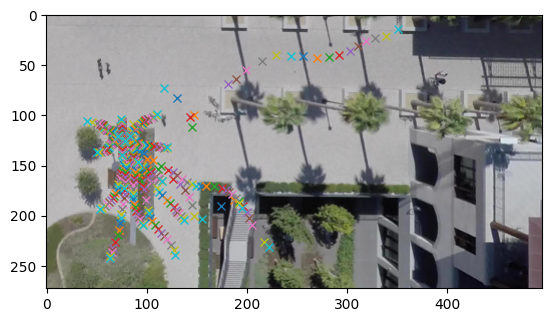

In [41]:
import matplotlib.pyplot as plt
from PIL import Image
import torch

# Load and resize the image
image = Image.open(demo_img + "/reference.jpg")
h, w = image.size
resized_image = image.resize((int(h * params["resize"]), int(w * params["resize"])))

# Display the resized image
plt.imshow(resized_image)
# Split and plot the data
x, y = torch.split(prediction.reshape(NUM_GOALS, PRED_LEN, 2), 1, dim=2)
x = x.reshape(NUM_GOALS, PRED_LEN)
y = y.reshape(NUM_GOALS, PRED_LEN)

plt.plot(x.cpu().numpy(), y.cpu().numpy(), 'x')
plt.show()


In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Define the desired dimensions
width = 500
height = 500
i = 0

# Iterate through subfolders and their files
for folder_name, subfolders, files in os.walk(TEST_IMAGE_PATH):
    for file_name in files:
        if file_name.lower().endswith(('.jpg')):
            sample = future_samples_list[i]
            # Get the full path of the image
            image_path = os.path.join(folder_name, file_name)
            image = mpimg.imread(image_path)

            # Check the image's dimensions
            img_width, img_height = image.shape[1], image.shape[0]

            # Determine the desired dimensions based on orientation
            if img_width > img_height:
                new_width = width
                new_height = height
            else:
                new_width = height
                new_height = width

            # Calculate extent parameters for resizing
            extent = [0, img_width, 0, img_height]
            extent = [extent[0], extent[0] + new_width, extent[2], extent[2] + new_height]

            # Display the image with resized extent
            plt.imshow(image, extent=extent)

            for trajectory_coords in sample:
                # Extract x and y coordinates from the trajectory
                x_coords = [point[0] for point in trajectory_coords]
                y_coords = [extent[2] + new_height - point[1] for point in trajectory_coords]

                # Plot each trajectory on the image
                plt.plot(x_coords, y_coords, marker='x', markersize=5)

            plt.xlabel("x")
            plt.ylabel("y")
            plt.title("Human Trajectory Prediction")
            plt.legend()
            plt.show()
            i += 1


Example: https://drive.google.com/file/d/1Aw7WTi1TauPO65LUEK71Sk3tgPptjM0D/view?usp=sharing